# Monthly SIF Animation
---

In [1]:
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
# from dask.distributed import Client
# client = Client(n_workers=16, dashboard_address=":8889")
# client = Client(n_workers=4)
# client

In [3]:
# Colormap
from matplotlib import colors
from palettable.scientific.sequential import Oleron_20

cm_sci = Oleron_20.mpl_colormap

# NOTE: this is almost identical to jet
nasa_palette = [
    "#03006d","#02008f","#0000b6","#0001ef","#0000f6",
    "#0428f6","#0b53f7","#0f81f3", "#18b1f5","#1ff0f7",
    "#27fada","#3efaa3","#5dfc7b","#85fd4e","#aefc2a",
    "#e9fc0d","#f6da0c","#f5a009", "#f6780a","#f34a09",
    "#f2210a","#f50008","#d90009","#a80109","#730005"]

cm_nasa = colors.LinearSegmentedColormap.from_list("nasa_palette", nasa_palette, N=256)

offset = colors.TwoSlopeNorm(vcenter=0., vmin=-0.5, vmax=1.)

## Read data and apply quality filters

In [4]:
def prep_sif(ds):
    """Preprocess a SIF Lite file"""
    
    # Drop unused variables
    variable_list = ["Daily_SIF_740nm", "SIF_Uncertainty_740nm", "Quality_Flag", "Longitude", "Latitude", "Delta_Time"]
    ds = ds[variable_list]
    
    # Apply quality filters
    ds["SIF_plus_3sig"] = ds.Daily_SIF_740nm + 3*ds.SIF_Uncertainty_740nm
    ds = ds.where(ds.Quality_Flag != 2, drop=True)
    ds = ds.where(ds.SIF_plus_3sig > 0, drop=True)

    # Format dataset
    dsnew = xarray.Dataset(
        {
            "sif": (["time"], ds.Daily_SIF_740nm),
        },
        coords={
            "lon": (["time"], ds.Longitude),
            "lat": (["time"], ds.Latitude),
            "time": ds.Delta_Time.values
        }
    )
    return dsnew

In [5]:
# Open multiple datasets across yearly subdirectories
# "/data/OCO-2/OCO2_L2_Lite_SIF.10r/*/*.nc4"
paths = "../data/OCO2_L2_Lite_SIF_10r/*/*.nc4"

DS = xarray.open_mfdataset(paths, preprocess=prep_sif, parallel=True)

## Plot monthly aggregates

In [6]:
def aggregate_grid(ds):
    # Map lat-lon to 1-degree bins
    lon_bins = np.arange(-180, 181)
    lat_bins = np.arange(-85, 86)
    lon_centers = np.arange(-179.5, 180.5)
    lat_centers = np.arange(-84.5, 85.5)
    
    df = ds.to_dataframe()
    df["lon"] = pd.cut(df.lon, lon_bins, labels=lon_centers).astype(float)
    df["lat"] = pd.cut(df.lat, lat_bins, labels=lat_centers).astype(float)

    # Group by bins, compute mean, return data array
    return df.groupby(["lon", "lat"]).mean().to_xarray()

In [8]:
# Compute bi-monthly averages over 1-degree bins 
DS_grid = DS.resample(time="SM").map(aggregate_grid)

In [11]:
DS_grid_1m = DS_grid.isel(time=-2)

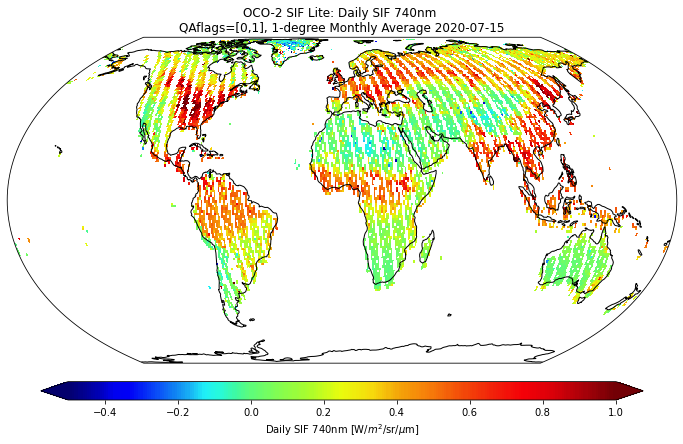

In [20]:
# Test figure setup
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(100,100)
ax = fig.add_subplot(gs[0:95, :], projection=ccrs.EqualEarth())
cbar_ax = fig.add_subplot(gs[95:, 5:95])

ax.set_global()

xarray.plot.imshow(DS_grid_1m.sif.T, transform=ccrs.PlateCarree(),
                    cmap=cm_nasa, extend="both", norm=offset,
                    ax=ax, cbar_ax=cbar_ax, 
                    cbar_kwargs={
                        "orientation": "horizontal", 
                        "label": "Daily SIF 740nm [W/$m^2$/sr/$\mu$m]"
                    })
ax.set_title(
    "OCO-2 SIF Lite: Daily SIF 740nm \n" 
    "QAflags=[0,1], 1-degree Monthly Average "
    f"{pd.to_datetime(DS_grid_1m.time.values).strftime('%Y-%m-%d')}"
    )

ax.coastlines();

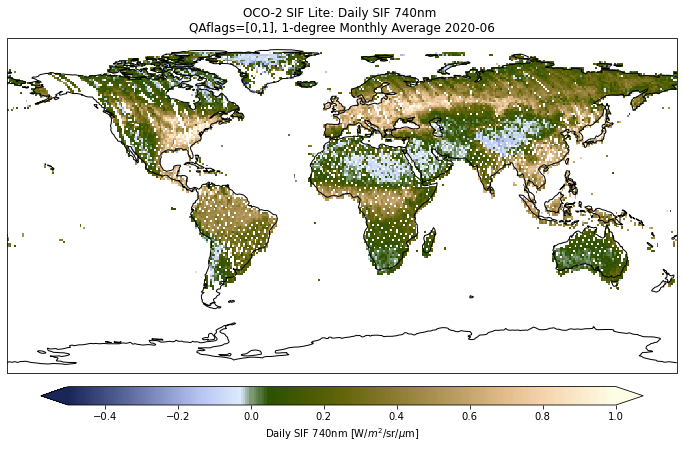

In [26]:
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(100,100)
ax = fig.add_subplot(gs[0:95, :], projection=ccrs.PlateCarree())
cbar_ax = fig.add_subplot(gs[95:, 5:95])

ax.set_global()

xarray.plot.imshow(DS_grid_1m.sif.T,
                    cmap=cm_sci, extend="both", norm=offset,
                    ax=ax, cbar_ax=cbar_ax, 
                    cbar_kwargs={
                        "orientation": "horizontal", 
                        "label": "Daily SIF 740nm [W/$m^2$/sr/$\mu$m]"
                    })
ax.set_title(
    "OCO-2 SIF Lite: Daily SIF 740nm \n" 
    "QAflags=[0,1], 1-degree Monthly Average "
    f"{pd.to_datetime(DS_grid_1m.time.values).strftime('%Y-%m')}"
    )

ax.coastlines();

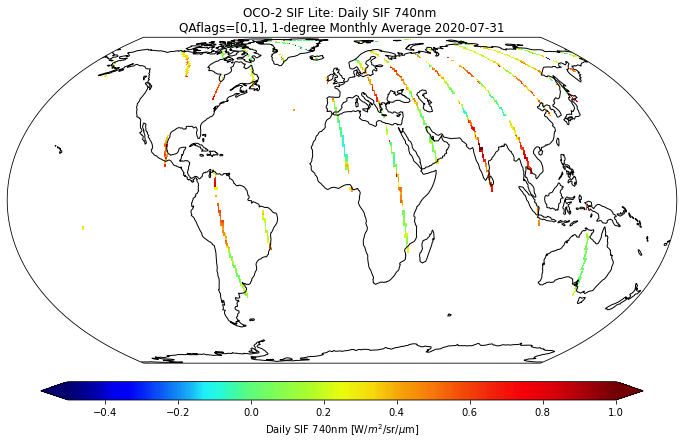

In [22]:
# Figure setup
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(100,100)
ax = fig.add_subplot(gs[0:95, :], projection=ccrs.EqualEarth())
cbar_ax = fig.add_subplot(gs[95:, 5:95])

def animate(month, cmap):
    """Update contour with new frame (each frame should be a monthly group)"""
    da = DS_grid.sif.isel(time=month)
    
    ax.clear()
    cbar_ax.clear()
    
    ax.set_global()
    xarray.plot.imshow(da.T, ax=ax, cbar_ax=cbar_ax,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap, extend="both", norm=offset,
                        cbar_kwargs={
                            "orientation": "horizontal", 
                            "label": "Daily SIF 740nm [W/$m^2$/sr/$\mu$m]"
                        })
    
    ax.coastlines()
    ax.set_title(
    "OCO-2 SIF Lite: Daily SIF 740nm \n" 
    "QAflags=[0,1], 1-degree Monthly Average "
    f"{pd.to_datetime(da.time.values).strftime('%Y-%m-%d')}"
    )
    

mov = FuncAnimation(fig, animate, frames=DS_grid.time.size, 
                    interval=500, fargs=(cm_nasa, ))

# HTML(mov.to_html5_video())
mov.save("../plots/Daily_SIF_740_bimonthly.mp4", fps=2, dpi=250)